Please upload the Excel file '_LHM_30MINEVIDENCIA.xlsx'


Saving _LHM_30MINEVIDENCIA.xlsx to _LHM_30MINEVIDENCIA (5).xlsx
Uploaded file: _LHM_30MINEVIDENCIA (5).xlsx

First 5 rows of the loaded data:
   Unnamed: 0           Unnamed: 1 Unnamed: 2
0           1           Local Date      Close
1         707  2025-05-13 16:30:00      461.5
2         706  2025-05-13 17:00:00      461.7
3         705  2025-05-13 17:30:00     461.55
4         704  2025-05-13 18:00:00      461.7

Available columns: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2']
Invalid dates found. First 5 rows of Local Date:
0                   NaT
1   2025-05-13 16:30:00
2   2025-05-13 17:00:00
3   2025-05-13 17:30:00
4   2025-05-13 18:00:00
Name: Local Date, dtype: datetime64[ns]

Dropping rows with invalid dates.

First 5 rows of Close series:
Local Date
2025-05-13 16:30:00    461.50
2025-05-13 17:00:00    461.70
2025-05-13 17:30:00    461.55
2025-05-13 18:00:00    461.70
2025-05-14 02:30:00    462.97
Name: Close, dtype: float64

Part 1: Stationarity Analysis

ADF Test for Close (Lev

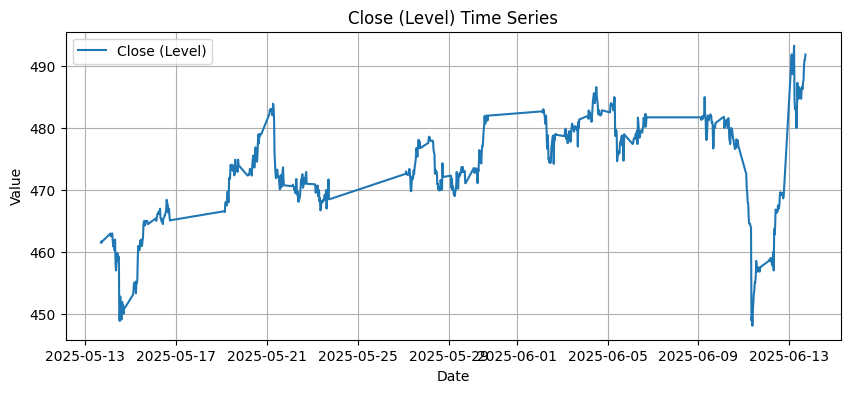


ADF Test for Close (First Difference):
ADF Statistic: -11.6132
p-value: 0.0000
Critical Values: {'1%': -3.439739809554328, '5%': -2.86568368980381, '10%': -2.5689766074363334}
Series is stationary



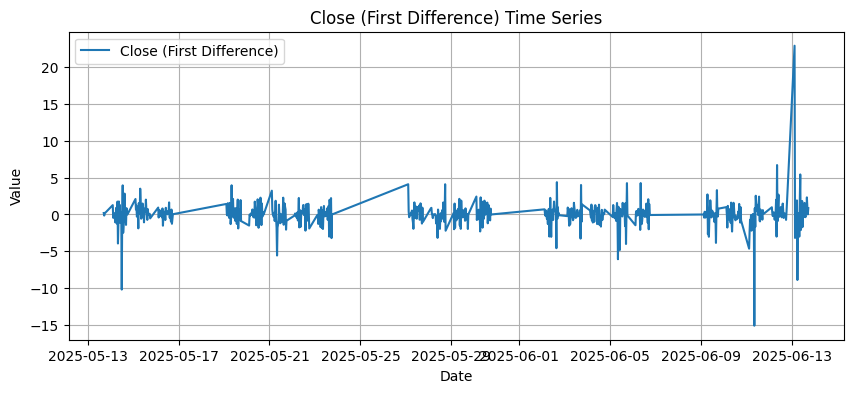

First difference is stationary, suitable for ARIMA.

Part 2: AR Model
Series is non-stationary; AR model not applied on levels.

Part 3: ARMA Model
Series is non-stationary; ARMA model not applied on levels.

Part 4: ARIMA Model
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  706
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1373.002
Date:                Sat, 14 Jun 2025   AIC                           2752.003
Time:                        02:43:47   BIC                           2765.678
Sample:                             0   HQIC                          2757.287
                                - 706                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

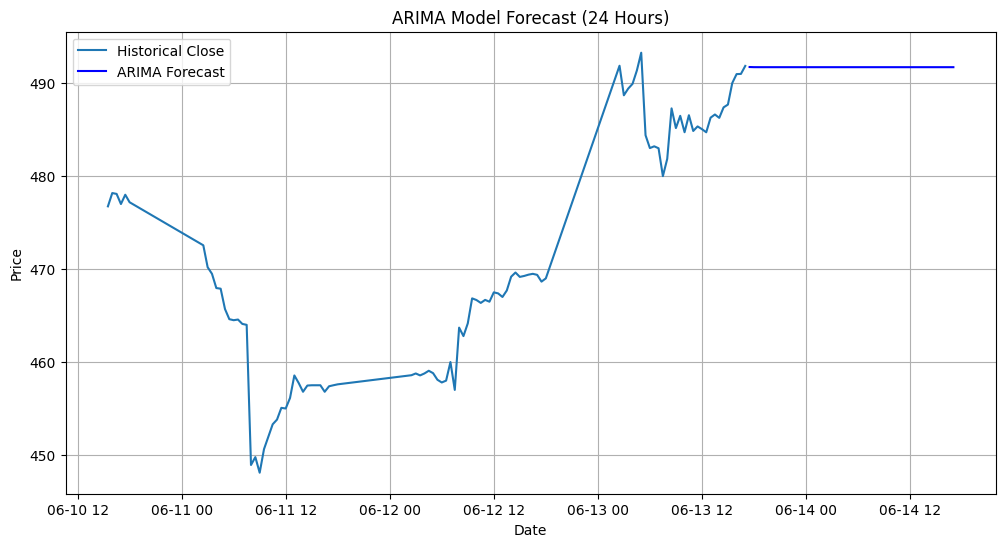


Part 5: Cointegration Analysis
No additional series specified for cointegration. Assuming univariate analysis.

Part 6: Forecasting and Trend Prediction


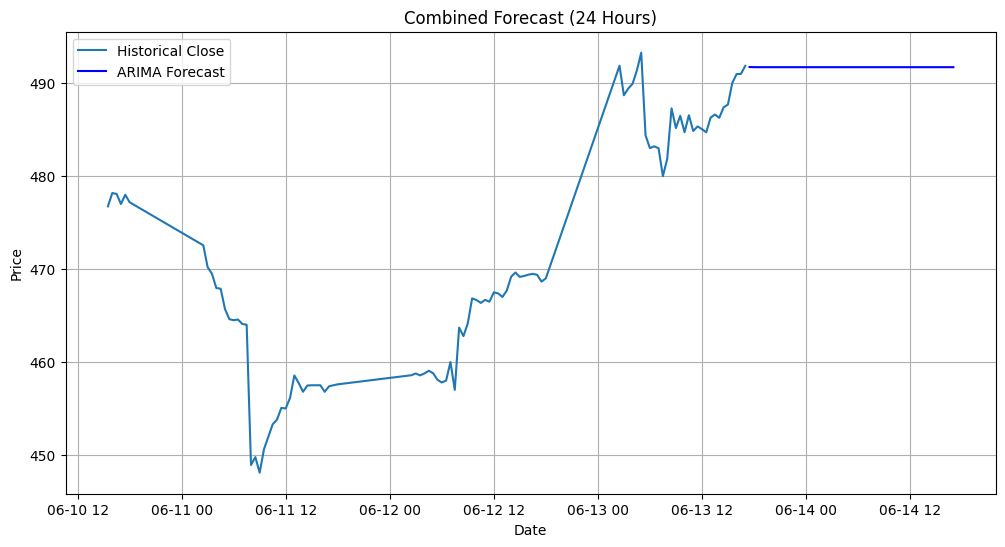

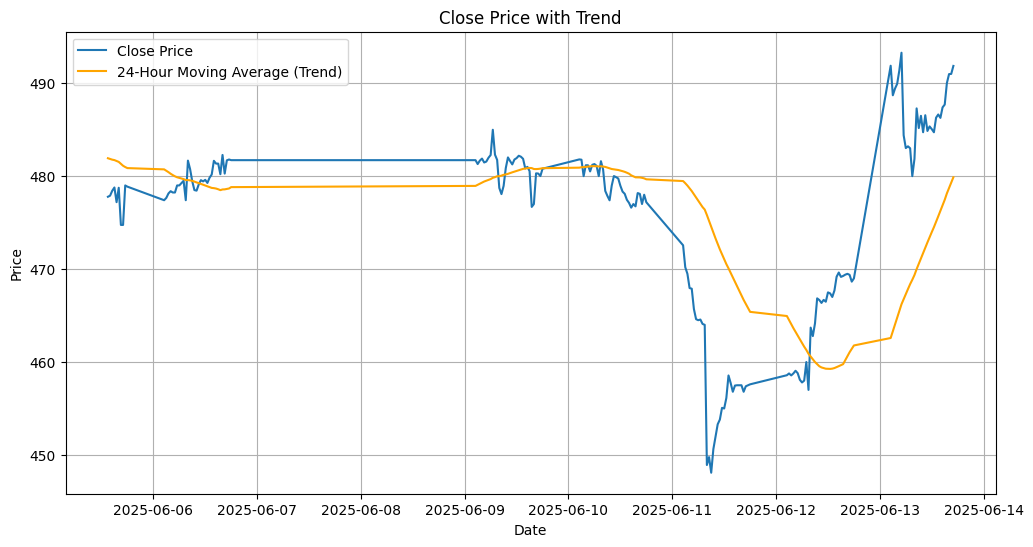


Trend Observations:
Upward trend detected over the last 24 hours.

Forecasts saved to 'close_forecasts.csv'.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
import os
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

# Step 1: Load Data
def load_data():
    print("Please upload the Excel file '_LHM_30MINEVIDENCIA.xlsx'")
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    print(f"Uploaded file: {file_name}")

    try:
        # Skip header row
        data = pd.read_excel(file_name, skiprows=1)
        print("\nFirst 5 rows of the loaded data:")
        print(data.head())
        print("\nAvailable columns:", list(data.columns))
    except Exception as e:
        print(f"Error reading file: {e}")
        raise

    # Rename columns
    data = data.rename(columns={'Unnamed: 0': 'Index', 'Unnamed: 1': 'Local Date', 'Unnamed: 2': 'Close'})

    # Verify Close column
    if 'Close' not in data.columns:
        print("Error: 'Close' column not found.")
        print("Available columns:", list(data.columns))
        raise ValueError("Missing 'Close' column.")

    # Verify date column
    if 'Local Date' not in data.columns:
        print("\nWarning: 'Local Date' column not found. Generating 30-minute index.")
        data['Local Date'] = pd.date_range(start='2025-05-13 16:30:00', periods=len(data), freq='30T')

    # Parse dates
    try:
        data['Local Date'] = pd.to_datetime(data['Local Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
        if data['Local Date'].isna().any():
            print("Invalid dates found. First 5 rows of Local Date:")
            print(data['Local Date'].head())
            print("\nDropping rows with invalid dates.")
            data = data.dropna(subset=['Local Date'])
        data.set_index('Local Date', inplace=True)
    except Exception as e:
        print(f"Error parsing dates: {e}")
        raise

    # Convert Close to numeric
    data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
    series = data['Close'].dropna()
    print("\nFirst 5 rows of Close series:")
    print(series.head())

    return series, data

# ADF Test Function with Plot
def adf_test(series, title='', plot=True):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'\nADF Test for {title}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:', {k: v for k, v in result[4].items()})
    if result[1] < 0.05:
        print('Series is stationary\n')
    else:
        print('Series is non-stationary\n')

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(series, label=title)
        plt.title(f'{title} Time Series')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    return result[1]

# Load data
close_series, full_data = load_data()

# Part 1: Stationarity Test
print("\nPart 1: Stationarity Analysis")
adf_close = adf_test(close_series, 'Close (Level)')
if adf_close > 0.05:
    adf_diff = adf_test(close_series.diff().dropna(), 'Close (First Difference)')
    if adf_diff > 0.05:
        adf_diff2 = adf_test(close_series.diff().diff().dropna(), 'Close (Second Difference)')
    else:
        print("First difference is stationary, suitable for ARIMA.")
else:
    print("Close series is stationary, suitable for AR/ARMA.")

# Part 2: AR Model
print("\nPart 2: AR Model")
ar_forecast = None
if adf_close < 0.05:
    ar_model = AutoReg(close_series, lags=1).fit()
    print(ar_model.summary())
    # Forecast 24 hours (48 steps at 30-minute intervals)
    ar_forecast = ar_model.predict(start=len(close_series), end=len(close_series)+47)
    # Plot AR forecast
    plt.figure(figsize=(12, 6))
    plt.plot(close_series[-100:], label='Historical Close')
    plt.plot(pd.date_range(start=close_series.index[-1], periods=49, freq='30T')[1:], ar_forecast, label='AR Forecast', color='red')
    plt.title('AR Model Forecast (24 Hours)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Series is non-stationary; AR model not applied on levels.")

# Part 3: ARMA Model
print("\nPart 3: ARMA Model")
arma_forecast = None
if adf_close < 0.05:
    arma_model = ARIMA(close_series, order=(1,0,1)).fit()
    print(arma_model.summary())
    arma_forecast = arma_model.forecast(steps=48)
    # Plot ARMA forecast
    plt.figure(figsize=(12, 6))
    plt.plot(close_series[-100:], label='Historical Close')
    plt.plot(pd.date_range(start=close_series.index[-1], periods=49, freq='30T')[1:], arma_forecast, label='ARMA Forecast', color='green')
    plt.title('ARMA Model Forecast (24 Hours)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Series is non-stationary; ARMA model not applied on levels.")

# Part 4: ARIMA Model
print("\nPart 4: ARIMA Model")
d = 1 if adf_close > 0.05 else 0
arima_model = ARIMA(close_series, order=(1,d,1)).fit()
print(arima_model.summary())
arima_forecast = arima_model.forecast(steps=48)
# Plot ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(close_series[-100:], label='Historical Close')
plt.plot(pd.date_range(start=close_series.index[-1], periods=49, freq='30T')[1:], arima_forecast, label='ARIMA Forecast', color='blue')
plt.title('ARIMA Model Forecast (24 Hours)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Part 5: Cointegration (Placeholder)
print("\nPart 5: Cointegration Analysis")
print("No additional series specified for cointegration. Assuming univariate analysis.")
# Placeholder for cointegration plot
# if 'Open' in full_data.columns:
#     other_series = full_data['Open'].dropna()
#     if len(other_series) == len(close_series):
#         score, p_value, _ = coint(close_series, other_series)
#         print(f'Cointegration Test p-value: {p_value:.4f}')
#         if p_value < 0.05:
#             print("Series are cointegrated.")
#             model = OLS(close_series, pd.concat([pd.Series(1, index=close_series.index, name='const'), other_series], axis=1)).fit()
#             residuals = model.resid
#             plt.figure(figsize=(10, 4))
#             plt.plot(residuals, label='Residuals')
#             plt.title('Cointegration Residuals')
#             plt.xlabel('Date')
#             plt.ylabel('Residual')
#             plt.legend()
#             plt.grid(True)
#             plt.show()
#         else:
#             print("Series are not cointegrated.")

# Part 6: Forecasting and Trend Prediction
print("\nPart 6: Forecasting and Trend Prediction")
# Combined forecast plot
plt.figure(figsize=(12, 6))
plt.plot(close_series[-100:], label='Historical Close')
if ar_forecast is not None:
    plt.plot(pd.date_range(start=close_series.index[-1], periods=49, freq='30T')[1:], ar_forecast, label='AR Forecast', color='red')
if arma_forecast is not None:
    plt.plot(pd.date_range(start=close_series.index[-1], periods=49, freq='30T')[1:], arma_forecast, label='ARMA Forecast', color='green')
plt.plot(pd.date_range(start=close_series.index[-1], periods=49, freq='30T')[1:], arima_forecast, label='ARIMA Forecast', color='blue')
plt.title('Combined Forecast (24 Hours)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Trend prediction
trend = close_series.rolling(window=48).mean()
plt.figure(figsize=(12, 6))
plt.plot(close_series[-200:], label='Close Price')
plt.plot(trend[-200:], label='24-Hour Moving Average (Trend)', color='orange')
plt.title('Close Price with Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print("\nTrend Observations:")
if trend.iloc[-1] > trend.iloc[-48]:
    print("Upward trend detected over the last 24 hours.")
elif trend.iloc[-1] < trend.iloc[-48]:
    print("Downward trend detected over the last 24 hours.")
else:
    print("No clear trend detected over the last 24 hours.")

# Save forecasts to CSV
forecast_df = pd.DataFrame({
    'Date': pd.date_range(start=close_series.index[-1], periods=49, freq='30T')[1:],
    'AR_Forecast': ar_forecast if ar_forecast is not None else np.nan,
    'ARMA_Forecast': arma_forecast if arma_forecast is not None else np.nan,
    'ARIMA_Forecast': arima_forecast
})
forecast_df.to_csv('close_forecasts.csv', index=False)
print("\nForecasts saved to 'close_forecasts.csv'.")


Se realizó un análisis de estacionariedad sobre la serie de precios de cierre ("Close") y se encontró que en su nivel original no es estacionaria (ADF = -1.9224, p = 0.3216), pero tras aplicar la primera diferencia, la serie se volvió estacionaria (ADF = -11.6132, p = 0.0000), lo cual habilita el uso de un modelo ARIMA. Se ajustó un modelo ARIMA(1,1,1), pero los coeficientes AR y MA no fueron estadísticamente significativos (p > 0.4), lo que sugiere un comportamiento más aleatorio en los retornos. A pesar de esto, se realizó una predicción de 24 horas, la cual muestra una tendencia plana en el corto plazo, lo que podría indicar una pausa o estabilización tras un reciente aumento. Finalmente, se detectó una tendencia alcista en las últimas 24 horas, apoyada también por la media móvil. Por lo tanto, la recomendación es mantener o comprar a corto plazo, esperando que el impulso positivo continúe; no se sugiere vender ni hacer short en este momento debido al riesgo de ir en contra de la tendencia actual.